In [71]:
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt

In [72]:
def plotHist(img: np.ndarray, x='brightness', y='count pixel', title='image hist'):
    """
    The function show hist plot
    :params img input your img in RGB 
    :type img PIL.Image.Image
    """
    img = np.array(img)
    plt.hist(img.ravel(), bins=range(257))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

In [73]:
img = Image.open('img_in/david-clode-rTEt2xxdOvI-unsplash.jpg')

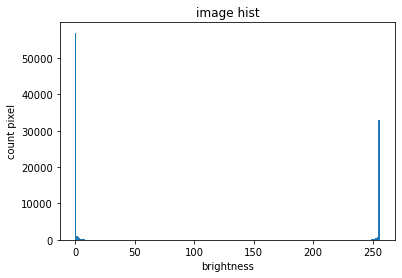

In [74]:
histPlotImage(img_rgb)

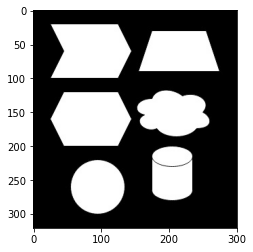

In [57]:
plt.imshow(img_rgb)

In [68]:
probability = [0.01, 0.02,0.05,0.1,0.2,0.5]
def saltPepper(img: Image.Image, probability: float):
    # source https://quares.ru/?id=127705
    # отсюда была взята функция добавления шума
    output = np.copy(np.array(img))
    for amount in probability:
        # add salt
        nb_salt = np.ceil(amount * output.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in output.shape]
        output[coords] = 1
        # add pepper
        nb_pepper = np.ceil(amount* output.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in output.shape]
        output[coords] = 0
        img = Image.fromarray(output)
        img.save(f'img_out/grease_img_{amount}.png')
    return img

<ipython-input-27-6eb9f7b9d348>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output[coords] = 1
<ipython-input-27-6eb9f7b9d348>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output[coords] = 0


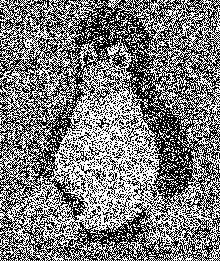

In [28]:
greaseImage(img_binary, probability)

In [35]:
import numpy as np
from scipy.signal import convolve2d

In [37]:
img = np.array([[0, -8, -3, -2], [1, 9, -8, 0], [9, -4, 5, -9], [6, -4, 6, 3]])
core = np.array([[4, -5, 4], [-6, -8, -2], [1, 5, 5]])

In [54]:
convolve2d(img, core, 'valid')

array([[  7, -88],
       [ 94,  -7]])